In [28]:
# # Setting up google drive
# from google.colab import drive
# drive.mount('/content/gdrive', force_remount=True)
# import sys
# sys.path.append('/content/gdrive/MyDrive/Colab Notebooks')

In [29]:
import my_utils as mu
import torch
from torch import nn

# The Task

* Our **Task** for this week is to implement LeNet.
* The Learning Outcome: Hands-on application of PyTorch's API for creating and training CNNs.



# LeNet

* At a high level, LeNet (LeNet-5) consists of 2 parts:
    1. a convolutional encoder consisting of two convolutional layers; and
    2. a dense block consisting of three fully-connected layers;


<!-- ![Data flow in LeNet. The input is a handwritten digit, the output a probability over 10 possible outcomes.](https://drive.google.com/uc?export=view&id=18Kd-JNGeKp38qAVEuxEyYU7rjNudWdWA) -->


![Data flow in LeNet. The input is a handwritten digit, the output a probability over 10 possible outcomes.](https://drive.google.com/uc?export=view&id=13EvZlXCSIovK6jA8uRvyZp9EE-PquOUx)



# LeNet -- Convolutional Encoder

* Each convolutional *block* consists of:
    * A convolutional layer.
    * A sigmoid activation function (ReLUs were discovered recently).
    * A subsequent average pooling operation (max pooling was discovered later).
* Each convolutional layer uses a $5\times 5$ kernel.
* The first convolutional layer has 6 output channels, while the second has 16.
* Each $2\times2$ pooling operation (stride 2) reduces dimensionality by a factor of $4$ via spatial downsampling.
* The convolutional block emits an output with shape given by (batch size, number of channels, height, width).



# LeNet -- Dense Block

* In order to pass the output from the convolutional block to the dense block, we must flatten each example in the minibatch.
* In other words, we take the four-dimensional input and transform it into the two-dimensional input expected by fully-connected layers:
    * the two-dimensional representation that we desire has uses the first dimension to index examples in the minibatch
    * the second to give the flat vector representation of each example.
* LeNet's dense block has three fully-connected layers, with 120, 84, and 10 outputs, respectively.
    * Because we are still performing classification, the 10-dimensional output layer corresponds to the number of possible output classes.

# Compressed LeNet Representation



 ![Compressed notation for LeNet-5.](https://drive.google.com/uc?export=view&id=1sL0P0_DwSU8vSOvcoV6GKkwwokyuKysS)


# Concise Implementation of LeNet

* Goal: use high-level APIs of PyTorch for implementing LeNet for classification.

In [30]:
# Read training and test data
batch_size = 256
train_iter, test_iter = mu.load_data_fashion_mnist(batch_size)
# type(train_iter)

# Defining the Model

* We will modify the code from MLP




In [31]:
class LeNet(torch.nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(LeNet, self).__init__()
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs
        C1 = 6
        C2 = 16
        L1 = 400
        L2 = 120
        L3 = 84
        self.Convl1 = nn.Conv2d(num_inputs, C1, kernel_size = 5, padding = 2)
        self.Sigmoid = nn.Sigmoid()
        self.Avg1 = nn.AvgPool2d(2, stride=2, padding=0)
        self.Convl2 = nn.Conv2d(C1,C2,kernel_size = 5)
        self.Avg2 = nn.AvgPool2d(2, stride=2, padding=0)
        self.Fltn = nn.Flatten()
        self.Linear1 = nn.Linear(L1, L2)
        self.Linear2 = nn.Linear(L2, L3)
        self.Linear3 = nn.Linear(L3, num_outputs)
    def forward(self, x):
        out = self.Convl1(x)
        out = self.Sigmoid(out)
        out = self.Avg1(out)
        out = self.Convl2(out)
        out = self.Sigmoid(out)
        out = self.Avg2(out)
        #out = self.Sigmoid(out)
        out = self.Fltn(out)
        out = self.Linear1(out)
        out = self.Sigmoid(out)
        out = self.Linear2(out)
        out = self.Sigmoid(out)
        out = self.Linear3(out)
        # out = self.Sigmoid(out)
        print(out.size())
        return out

In [32]:
class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()

    def forward(x):
        pass



class Block(torch.nn.Module):
    def __init__(self, k, in_channels, out_channels):
        super(Block, self).__init__()
        self.k = k
        self.out_channels = out_channels
        self.in_channels = in_channels
        
        # defining weight calculations (a)
        
        
        self.spatialAvgPool = nn.AdaptiveAvgPool2d(1)
        # flatten
        self.aLinear1 = nn.Linear(in_features=in_channels, out_features=k) 
        self.Sigmoid = nn.Sigmoid()
        
        # ===============temp
        self.TEMP = nn.Linear(in_features=3920, out_features=10)
        # ===============temp
        
        # defining the convolution section
        
        # creates k convolutions
        self.convs = nn.ModuleList([nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=5 ,padding=2) for _ in range(k)])
        

    def forward(self, x):
        
        # Apply spatial average pooling
        pooled = self.spatialAvgPool(x)
        # Flatten the output for the linear layer
        pooled = pooled.view(pooled.size(0), -1)
        # Obtain the weights
        a = self.Sigmoid(self.aLinear1(pooled)) # creates vector of size k
        
        # Initialize the output tensor O
        O = torch.zeros_like(self.convs[0](x))
        
        # Apply the convolutions and accumulate the weighted sum
        for i in range(self.k):
            O += a[:, i].view(-1, 1, 1, 1) * self.convs[i](x) #  a_i * conv_i(X)
        O = O.reshape(-1, 3920) # 5 x 28 x 28
        O = self.TEMP(O)
        if not isinstance(O, torch.Tensor):
            raise TypeError(f"Expected O to be a torch.Tensor but got {type(O)}")
        print(O.size())

        return
        

In [33]:
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d: # by checking the type we can init different layers in different ways
        torch.nn.init.xavier_uniform_(m.weight)

num_outputs = 10
#model = LeNet(num_outputs)
# model = LeNet(1, num_outputs)

model = Block(3,1,5)
# model.apply(init_weights);
print(model)

Block(
  (spatialAvgPool): AdaptiveAvgPool2d(output_size=1)
  (aLinear1): Linear(in_features=1, out_features=3, bias=True)
  (Sigmoid): Sigmoid()
  (TEMP): Linear(in_features=3920, out_features=10, bias=True)
  (convs): ModuleList(
    (0-2): 3 x Conv2d(1, 5, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
)


# Loss and Optimization Algorithm
* As in Softmax Regression

In [34]:
loss = nn.CrossEntropyLoss()
lr = 0.9
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

# Training

* Use `my_utils.train_ch3` as in Softmax Regression

torch.Size([256, 10])


AttributeError: 'NoneType' object has no attribute 'size'

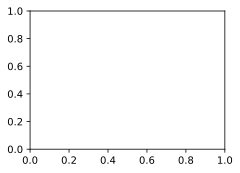

In [35]:
num_epochs = 20
mu.train_ch3(model, train_iter, test_iter, loss, num_epochs, optimizer)